In [2]:
# from the pymice package 
# https://github.com/RianneSchouten/pymice

import numpy as np
import pandas as pd
import math as ma
import scipy.stats as st
import seaborn as sns

def checks_input_mcar_tests(data):
    """ Checks whether the input parameter of class McarTests is correct
            Parameters
            ----------
            data:
                The input of McarTests specified as 'data'
            Returns
            -------
            bool
                True if input is correct
            """

    if not isinstance(data, pd.DataFrame):
        print("Error: Data should be a Pandas DataFrame")
        return False

    if not any(data.dtypes.values == np.float):
        if not any(data.dtypes.values == np.int):
            print("Error: Dataset cannot contain other value types than floats and/or integers")
            return False

    if not data.isnull().values.any():
        print("Error: No NaN's in given data")
        return False

    return True


def mcar_test(data):
    """ Implementation of Little's MCAR test
    Parameters
    ----------
    data: Pandas DataFrame
        An incomplete dataset with samples as index and variables as columns
    Returns
    -------
    p_value: Float
        This value is the outcome of a chi-square statistical test, testing whether the null hypothesis
        'the missingness mechanism of the incomplete dataset is MCAR' can be rejected.
    """

    if not checks_input_mcar_tests(data):
        raise Exception("Input not correct")

    dataset = data.copy()
    vars = dataset.dtypes.index.values
    n_var = dataset.shape[1]

    # mean and covariance estimates
    # ideally, this is done with a maximum likelihood estimator
    gmean = dataset.mean()
    gcov = dataset.cov()

    # set up missing data patterns
    r = 1 * dataset.isnull()
    mdp = np.dot(r, list(map(lambda x: ma.pow(2, x), range(n_var))))
    sorted_mdp = sorted(np.unique(mdp))
    n_pat = len(sorted_mdp)
    correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
    dataset['mdp'] = pd.Series(correct_mdp, index=dataset.index)

    # calculate statistic and df
    pj = 0
    d2 = 0
    for i in range(n_pat):
        dataset_temp = dataset.loc[dataset['mdp'] == i, vars]
        select_vars = ~dataset_temp.isnull().any()
        pj += np.sum(select_vars)
        select_vars = vars[select_vars]
        means = dataset_temp[select_vars].mean() - gmean[select_vars]
        select_cov = gcov.loc[select_vars, select_vars]
        mj = len(dataset_temp)
        parta = np.dot(means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1])))
        d2 += mj * (np.dot(parta, means))

    df = pj - n_var

    # perform test and save output
    p_value = 1 - st.chi2.cdf(d2, df)

    return p_value

You will work with a classification dataset on heart disease. 

Please check the description (heart-disease.names) and the data (cleveland.data) in the data folder.

The code below is provided to load the data into a data frame.

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib
from matplotlib import pylab as plt

In [20]:
import pandas as pd
import numpy  as np

# Let's load the data

feature_names = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach',\
                'exang','oldpeak','slope','ca','thal']
label = 'num'
df = pd.read_csv('data/cleveland.data',header=None)
df.columns = feature_names + [label]

df.replace(to_replace='?',value = np.nan, inplace=True) # replace '?' with nans

df = df.astype(float) # column types need to be numeric for the mcar_test to work

print(df.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0  0.0  
1    2.0  3.0   3.0  2.0  
2    2.0  2.0   7.0  1.0  
3    3.0  0.0   3.0  0.0  
4    1.0  0.0   3.0  0.0  


Problem 1 (4 points):

Please handle the missing values in the data and justify your decision. If you decide to drop the points with missing values, please use `.reset_index(drop=True, inplace=True)` on your dataframe after droping the rows to avoid any issues with the index column down the road.

In [21]:
# print(df.shape)
print(df.isnull().sum(axis=0)/df.shape[0])
print(sum(df.isnull().sum(axis=1)!=0)/df.shape[0])

age         0.000000
sex         0.000000
cp          0.000000
trestbps    0.000000
chol        0.000000
fbs         0.000000
restecg     0.000000
thalach     0.000000
exang       0.000000
oldpeak     0.000000
slope       0.000000
ca          0.013201
thal        0.006601
num         0.000000
dtype: float64
0.019801980198019802


**Solution:**   
As we can see in the description of the data file, both 'ca' and 'thal' are categorical features. Since they are the only two feature contains missing values, we can treat the missing values as one separate category of each. Since the catagories are represented by integers and none of the categories is 9, we define the missing catagory as 9. For preprocessing the missing values, we deal it with the one-hot encoder, so the missing value will be handled in problem 2. 

Problem 2: (8 points)

Please preprocess the features. If you can't complete this within 30 min, move on to problems 3 and 4. If preprocessing is not completed, you can still get full points for problems 3 and 4.

In [28]:
# TODO: sex, exang, and fbs are already binary features, which means we don't need to preprocess them. 
bin_ftrs = ['sex','exang','fbs']
cat_ftrs = ['cp','restecg','slope', 'ca', 'thal']
num_ftrs = ['age', 'trestbps','chol','thalach','oldpeak']
label = ['num']

In [29]:
# one-hot encoder
ohe = OneHotEncoder(sparse=False)
si = SimpleImputer(strategy='constant',fill_value=9)
cat_values = ohe.fit_transform(si.fit_transform(df[cat_ftrs]))
cat_ftr_names = ohe.get_feature_names(cat_ftrs)
df_cat = pd.DataFrame(data=cat_values,columns = cat_ftr_names)
df_bin = df[bin_ftrs]

# standard scaler
ss = StandardScaler()
num_values = ss.fit_transform(df[num_ftrs])
df_num = pd.DataFrame(data=num_values,columns = num_ftrs)

label
le = LabelEncoder()
label_values = le.fit_transform(df[label])
df_label = pd.DataFrame(data=label_values, columns = label)

df_preprocessed = pd.concat([df_cat,df_num,df_bin],axis=1)
print(df_preprocessed.shape)
df_preprocessed.head()

(303, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,...,thal_7.0,thal_9.0,age,trestbps,chol,thalach,oldpeak,sex,exang,fbs
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.948726,0.757525,-0.264900,0.017197,1.087338,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.392002,1.611220,0.760415,-1.821905,0.397182,1.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.932564,-0.096170,0.063974,1.637359,2.122573,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,-1.489288,-0.096170,-0.825922,0.980537,0.310912,0.0,0.0,0.0


Problem 3: (5 points)

Which feature has the strongest linear dependency with the target variable?

In [30]:
# TODO: need to use select k best, instead of correlation
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest

X = df_preprocessed.values
# change matrix to array
y = df_label.values.ravel()
# need to have this line in order to run the code
feature_names = df_preprocessed.columns
f_select = SelectKBest(f_regression,k=1)
X_f = f_select.fit_transform(X,y)
f_select.get_support()
feature_names[f_select.get_support()]


Index(['thal_3.0'], dtype='object')

**Solution:**    
I get the correlation matrix from the pre processed data, and the feature 'thal_3.0' is has the strongest linear dependency with 'num'

Problem 4: (3 points)

Prepare one visualization using the feature selected above and the target variable.

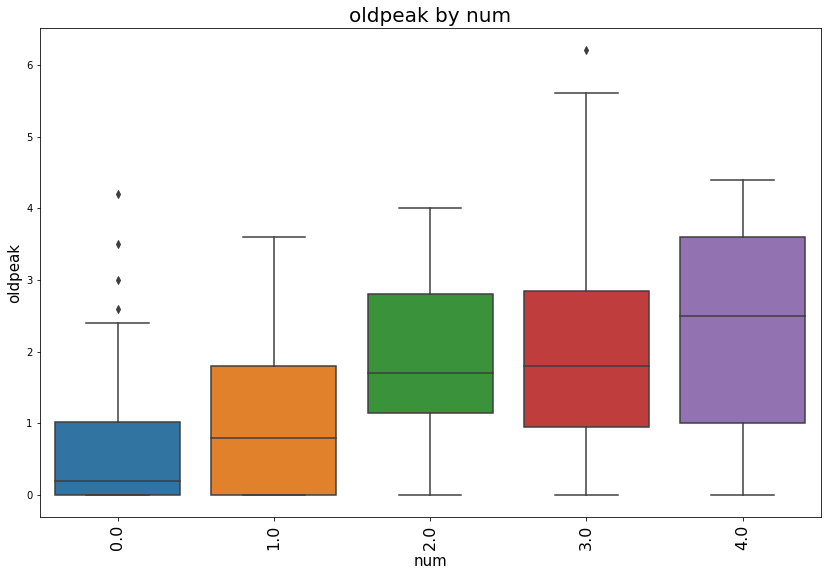

In [31]:
plt.figure(figsize = (14,9))
f = sns.boxplot(x='num', y='oldpeak', data=df)
f.set_xticklabels(f.get_xticklabels(),rotation=90, fontsize = 16)
f.set_title("oldpeak by num", fontsize=20)
f.set_xlabel("num", fontsize=15)
f.set_ylabel("oldpeak", fontsize=15)
plt.show()

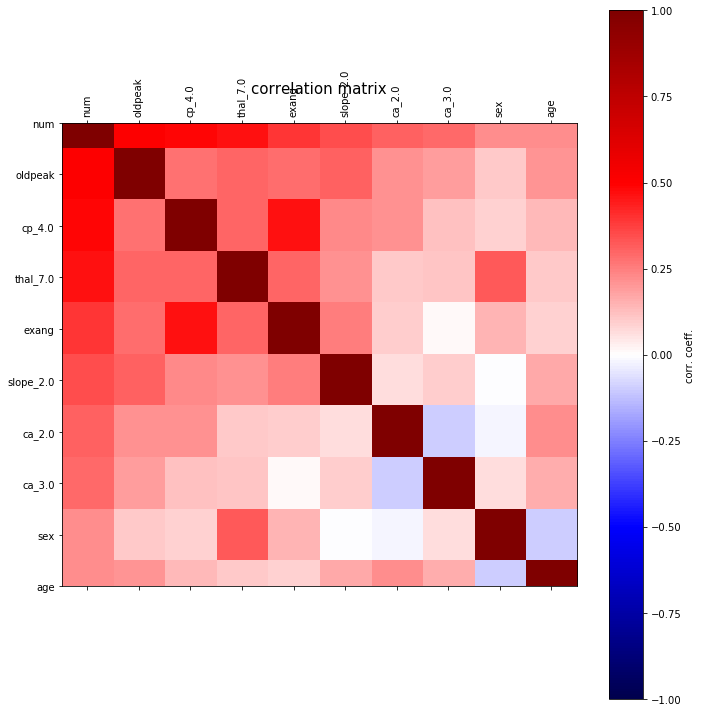

In [32]:
df_preprocessed = pd.concat([df_preprocessed,df_label],axis=1)
df_preprocessed
corrmat = df_preprocessed.corr()

all_cols = corrmat.sort_values('num',ascending=False)['num'].index 
cols = all_cols[:10] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
plt.title("correlation matrix", fontsize = 15)
# plt.savefig('figures/corr_coeff_dummies.png',dpi=300)
plt.show()

In [33]:
import pandas as pd
import numpy  as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn.svm import SVC

Problem 1) We will create a kfold CV pipeline for the heart disease dataset you worked with during the midterm exam.

Problem 1a) Read in the data and drop the rows with missing values. Remember that the dataset does not contain the feature names! Separate out the feature matrix (X) and the target variable (y). What is the balance of this dataset (the baseline accuracy)? (2 points)

In [34]:
# Read in the data
df = pd.read_csv('data/cleveland.data',header=None)

# set feature and label names
feature_names = ['age','sex','cp','trestbps','chol','fbs','restecg',
                 'thalach','exang','oldpeak','slope','ca','thal']
label = 'num'
df.columns = feature_names + [label]

# replace '?' with nans
df.replace(to_replace='?',value = np.nan, inplace=True)

# drop the rows with missing value
df = df.dropna()
df.reset_index(drop=True, inplace=True)

# Separate out the feature matrix (X) and the target variable (y)
X = df[feature_names]
y = df[label]

X = X.values
y = y.values
# What is the balance of this dataset (the baseline accuracy)?
balance = df[label].value_counts()/df[label].shape
print("The balance of the dataset is", np.around(balance[0],4)*100, "%")

The balance of the dataset is 53.87 %


Problem 1b) ML pipeline with logistic regression

Split your data in a stratified manner into `other` and `test` (20% in `test`) and then split `other` into 5 stratified folds. 4 of those folds will be used for training, the last fold will be CV. You'll need to loop through the 5 options the CV fold can be selected. (4 points)

Preprocess the data. Apply the OneHotEncoder and the StandardScaler to the appropriate columns. Make sure to fit_transform only train (4 out of the 5 folds). The CV and test sets should be transformed based on the preprocessor fitted to train. (2 points)

Train a logistic regression model with l1 regularization and tune the appropriate parameter. (4 points)

Repeat the procedure 10 times with 10 different random states and print the mean and std of the test accuracy score. Make sure to print the best parameters and check that the best values are not at the edge of your parameter space if possible. Check that your code is reproducable! That is, if you rerun the cell, you get back the exact same result. (3 points)


In [35]:
# train lasso
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state, stratify = y)
    CV_scores = []
    test_scores = []
    # k folds - each fold will give us a CV and a test score
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # loop through 5 selected folders
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]
    
        label = ['num']
        # preprocessing - continuous feature
        scaler = StandardScaler()
#         num_ftrs = ['age', 'trestbps','chol','thalach','oldpeak']
        num_ftrs = [0,3,4,7,9]
        X_train_num = scaler.fit_transform(X_train[:,num_ftrs])
        X_c_num = scaler.transform(X_CV[:,num_ftrs])
        X_t_num = scaler.transform(X_test[:,num_ftrs])

        # preprocessing - cat features
        ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")
#         cat_ftrs = ['sex', 'cp', 'fbs', 'restecg','exang','slope', 'ca', 'thal']
#         cat_ftrs = [1,2,5,6,8,10,11,12]
        cat_ftrs = [2,10,12]
        X_train_cat = ohe.fit_transform(X_train[:,cat_ftrs])
#         print('X_train_cat', X_train_cat)
        X_c_cat = ohe.transform(X_CV[:,cat_ftrs])
#         print('X_c_cat', X_c_cat)
        X_t_cat = ohe.transform(X_test[:,cat_ftrs])
        
        # binary features
#         bin_ord_ftrs = ['sex', 'fbs', 'exang', 'ca', 'restecg']
        bi_ftrs = [1,5,6,8,11]
        X_train_bi = X_train[:,bi_ftrs]
        X_c_bi = X_CV[:,bi_ftrs]
        X_t_bi = X_test[:,bi_ftrs]

        X_train_prep = np.concatenate((X_train_cat,X_train_num,X_train_bi),axis=1)
        X_c = np.concatenate((X_c_cat,X_c_num, X_c_bi),axis=1)
        X_t = np.concatenate((X_t_cat,X_t_num, X_t_bi),axis=1)
        X_train = X_train_prep
        
        # tune lasso hyper-parameter, alpha
        alpha = np.logspace(-2,2,num=8)
        train_score = []
        CV_score = []
        regs = []
        for a in alpha:
            reg = LogisticRegression(penalty='l1',C = 1/a, multi_class = 'multinomial', 
                                     solver='saga', max_iter = 1e4)
            reg.fit(X_train,y_train)
            train_score.append(accuracy_score(y_train,reg.predict(X_train)))
            CV_score.append(accuracy_score(y_CV,reg.predict(X_c)))
            regs.append(reg)
        # find the best alpha in this fold
        best_alpha = alpha[np.argmax(CV_score)]
        # grab the best model
        reg = regs[np.argmax(CV_score)]
        CV_scores.append(np.max(CV_score))
        # calculate test score using the best model
        test_scores.append(accuracy_score(y_test,reg.predict(X_t)))
        
    print("The best alpha is", best_alpha)
    return CV_scores,test_scores

test_scores = []

for i in range(10):
    grid, test_score = ML_pipeline_kfold(X,y,42*i,5)
    test_scores.append(test_score)
print("Lasso best accuracy is ",np.around(np.mean(test_scores),2), '+/-', np.around(np.std(test_scores),2))

# Lasso best accuracy is  0.58 +/- 0.03

The best alpha is 0.01
The best alpha is 0.517947467923121
The best alpha is 1.9306977288832496
The best alpha is 0.01
The best alpha is 0.01
The best alpha is 1.9306977288832496
The best alpha is 0.517947467923121
The best alpha is 0.517947467923121
The best alpha is 7.196856730011514
The best alpha is 1.9306977288832496
Lasso best accuracy is  0.58 +/- 0.03


Problem 1d) Train a random forest classifier and tune the appropriate parameters. Make sure to print the best parameters and check that the best values are not at the edge of your parameter space if possible. Repeat the procedure 10 times with 10 different random states and print the mean and std of the test accuracy score. Check that your code is reproducable! That is, if you rerun the cell, you get back the exact same result. (5 points)

In [36]:
# train random forest
def ML_pipeline_kfold(X,y,random_state,n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify = y)
    CV_scores = []
    test_scores = []
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True,random_state=random_state)
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]

        scaler = StandardScaler()
#         num_ftrs = ['age', 'trestbps','chol','thalach','oldpeak']
        num_ftrs = [0,3,4,7,9]
        X_train_num = scaler.fit_transform(X_train[:,num_ftrs])
        X_c_num = scaler.transform(X_CV[:,num_ftrs])
        X_t_num = scaler.transform(X_test[:,num_ftrs])

        # preprocessing - cat features
        ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")
#         cat_ftrs = ['sex', 'cp', 'fbs', 'restecg','exang','slope', 'ca', 'thal']
#         cat_ftrs = [1,2,5,6,8,10,11,12]
        cat_ftrs = [2,10,12]
        X_train_cat = ohe.fit_transform(X_train[:,cat_ftrs])
#         print('X_train_cat', X_train_cat)
        X_c_cat = ohe.transform(X_CV[:,cat_ftrs])
#         print('X_c_cat', X_c_cat)
        X_t_cat = ohe.transform(X_test[:,cat_ftrs])
        
        # binary features
#         bin_ord_ftrs = ['sex', 'fbs', 'exang', 'ca', 'restecg']
        bi_ftrs = [1,5,6,8,11]
        X_train_bi = X_train[:,bi_ftrs]
        X_c_bi = X_CV[:,bi_ftrs]
        X_t_bi = X_test[:,bi_ftrs]

        X_train_prep = np.concatenate((X_train_cat,X_train_num,X_train_bi),axis=1)
        X_c = np.concatenate((X_c_cat,X_c_num, X_c_bi),axis=1)
        X_t = np.concatenate((X_t_cat,X_t_num, X_t_bi),axis=1)
        X_train = X_train_prep

        # tune random forest hyper-parameter, depth and min sample split
        depths = [i for i in range(1,15)]
        sss = [i for i in range(5,15)]
        train_score = defaultdict(lambda: 0)
        CV_score = defaultdict(lambda: 0)
        regs = defaultdict(lambda: RandomForestClassifier(n_estimators=10, max_depth=2, min_samples_split=2, random_state=random_state))
        for i,depth in enumerate(depths):
            for j,ss in enumerate(sss):
                reg = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=ss, random_state=random_state)
                reg.fit(X_train, y_train)
                train_score[(i,j)] = accuracy_score(y_train, reg.predict(X_train))
                CV_score[(i,j)] = accuracy_score(y_CV, reg.predict(X_c))
                regs[(i,j)] = reg
        # find the best alpha in this fold
        best_CV_pair = max(CV_score, key=CV_score.get)
        best_depths = depths[best_CV_pair[0]]
        best_sss = sss[best_CV_pair[1]]
        # grab the best model
        reg = regs[best_CV_pair]
        CV_scores.append(np.max(CV_score))
        # calculate test score using thee best model
        test_scores.append(accuracy_score(y_test, reg.predict(X_t)))
    
    print("best max_depths is ", best_depths)
    print("best min sample splits is ", best_sss)
    return CV_scores, test_scores


test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold(X,y,42*i,5)
    test_scores.append(test_score)
print("Random Tree best accuracy is ",np.around(np.mean(test_scores),2), '+/-', np.around(np.std(test_scores),2))


best max_depths is  3
best min sample splits is  12
best max_depths is  7
best min sample splits is  5
best max_depths is  4
best min sample splits is  9
best max_depths is  4
best min sample splits is  5
best max_depths is  7
best min sample splits is  8
best max_depths is  7
best min sample splits is  11
best max_depths is  2
best min sample splits is  5
best max_depths is  6
best min sample splits is  11
best max_depths is  9
best min sample splits is  8
best max_depths is  4
best min sample splits is  14
Random Tree best accuracy is  0.58 +/- 0.03


Problem 1e) Train an SVC and tune the appropriate parameters. Make sure to print the best parameters and check that the best values are not at the edge of your parameter space if possible. Repeat the procedure 10 times with 10 different random states and print the mean and std of the test accuracy score. Check that your code is reproducable! That is, if you rerun the cell, you get back the exact same result. (4 points)

In [37]:
# Train an SVC

def ML_pipeline_kfold(X,y,random_state,n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify = y)
    CV_scores = []
    test_scores = []
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True,random_state=random_state)
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other[train_index], X_other[CV_index]
        y_train, y_CV = y_other[train_index], y_other[CV_index]

        scaler = StandardScaler()
#         num_ftrs = ['age', 'trestbps','chol','thalach','oldpeak']
        num_ftrs = [0,3,4,7,9]
        X_train_num = scaler.fit_transform(X_train[:,num_ftrs])
        X_c_num = scaler.transform(X_CV[:,num_ftrs])
        X_t_num = scaler.transform(X_test[:,num_ftrs])

        # preprocessing - cat features
        ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")
#         cat_ftrs = ['sex', 'cp', 'fbs', 'restecg','exang','slope', 'ca', 'thal']
#         cat_ftrs = [1,2,5,6,8,10,11,12]
        cat_ftrs = [2,10,12]
        X_train_cat = ohe.fit_transform(X_train[:,cat_ftrs])
#         print('X_train_cat', X_train_cat)
        X_c_cat = ohe.transform(X_CV[:,cat_ftrs])
#         print('X_c_cat', X_c_cat)
        X_t_cat = ohe.transform(X_test[:,cat_ftrs])
        
        # binary features
#         bin_ord_ftrs = ['sex', 'fbs', 'exang', 'ca', 'restecg']
        bi_ftrs = [1,5,6,8,11]
        X_train_bi = X_train[:,bi_ftrs]
        X_c_bi = X_CV[:,bi_ftrs]
        X_t_bi = X_test[:,bi_ftrs]

        X_train_prep = np.concatenate((X_train_cat,X_train_num,X_train_bi),axis=1)
        X_c = np.concatenate((X_c_cat,X_c_num, X_c_bi),axis=1)
        X_t = np.concatenate((X_t_cat,X_t_num, X_t_bi),axis=1)
        X_train = X_train_prep

        # tune svc hyper-parameter, gamma and c 
        gammas= np.logspace(-9, 3, 13)
        Cs = np.logspace(1, 10, 10)
        train_score = defaultdict(lambda: 0)
        CV_score = defaultdict(lambda: 0)
        regs = defaultdict(lambda: SVC(gamma = 1, C = 1, probability=True, random_state=random_state))
        for i,gamma_value in enumerate(gammas):
            for j,c in enumerate(Cs):
                reg = SVC(gamma = gamma_value, C = c, probability=True)
                reg.fit(X_train, y_train)
                train_score[(i,j)] = accuracy_score(y_train, reg.predict(X_train))
                CV_score[(i,j)] = accuracy_score(y_CV, reg.predict(X_c))
                regs[(i,j)] = reg
        # find the best alpha in this fold
        best_CV_pair = max(CV_score, key=CV_score.get)
        best_gamma = gammas[best_CV_pair[0]]
        best_c = Cs[best_CV_pair[1]]
        # grab the best model
        reg = regs[best_CV_pair]
        CV_scores.append(np.max(CV_score))
        # calculate test score using thee best model
        test_scores.append(accuracy_score(y_test, reg.predict(X_t)))
    
    print("best gamma is ", best_gamma)
    print("best c is ", best_c)
    return CV_scores, test_scores

test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold(X,y,42*i,5)
    test_scores.append(test_score)
print("SVC best accuracy is ",np.around(np.mean(test_scores),2), '+/-', np.around(np.std(test_scores),2))

best gamma is  1e-07
best c is  100000.0
best gamma is  0.01
best c is  100.0
best gamma is  1e-09
best c is  100000000.0
best gamma is  0.001
best c is  1000.0
best gamma is  0.001
best c is  10000.0
best gamma is  1e-06
best c is  100000.0
best gamma is  1.0
best c is  10.0
best gamma is  1e-08
best c is  100000000.0
best gamma is  1e-06
best c is  10000000.0
best gamma is  1e-08
best c is  10000000.0
SVC best accuracy is  0.56 +/- 0.04


Problem 1f) Compare the means and standard deviations of the three techniques. How many standard deviations above the baseline accuracy are the three models? How would you rank them with respect of accuracy? (3 points)

In [38]:
# 1f)
print("Lasso regularization:", (0.58-0.5387)/0.03)
print("Random Forest:", (0.58-0.5387)/0.03)
print("SVC:", (0.56-0.5387)/0.04)

Lasso regularization: 1.376666666666667
Random Forest: 1.376666666666667
SVC: 0.5325000000000024


**Solution:**   
The random forest and the Lasso regularization are better than the SVC. 